# Predicting Bounding Boxes

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

- [Initial steps](#0)
  - [0.1 Imports](#0-1)
  - [0.2 Download and Extract the Dataset](#0-1)
- [1. Visualization Utilities](#1)
  - [1.1 Bounding Boxes Utilities](#1-1)
  - [1.2 Data and Predictions Utilities](#1-2)
- [2. Preprocessing and Loading the Dataset](#2)
  - [2.1 Preprocessing Utilities](#2-1)
  - [2.2 Visualize the prepared Data](#2-2)
  - [2.3 Loading the Dataset](#2-3)
- [3. Define the Network](#3)
  - [Building a feature extractor using MobileNetV2.](#ex-01)
  - [Defining the dense layers](#ex-02)
  - [Define a layer that outputs the bounding box predictions](#ex-03)
  - [Construct the model](#ex-04)
  - [compile the model5](#ex-05)
- [4. Training the Model](#4)
- [5. Validate the Model](#5)
  - [5.1 Loss](#5-1)
  - [5.2 Plot the Loss Function](#5-2)  
  - [5.3 Evaluate performance using IoU](#5-3)
- [6. Visualize Predictions](#6)
- [7. Save the Model](#7)


<a name="0-1"></a>
## 0.1 Imports

In [2]:
import os, re, time, json, zipfile
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

2024-07-14 14:02:43.028990: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 14:02:43.029094: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 14:02:43.162476: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<a name="0-2"></a>
## 0.2 Download and Extract the Dataset



In [3]:
# Download the dataset
# !cd /kaggle/input
!wget https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


--2024-07-14 14:02:55--  https://storage.googleapis.com/tensorflow-3-public/datasets/caltech_birds2010_011.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.203.207, 74.125.135.207, 74.125.142.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.203.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 688150437 (656M) [application/zip]
Saving to: 'caltech_birds2010_011.zip'

caltech_birds2010_0 100%[===================>] 656.27M   174MB/s    in 3.8s    

2024-07-14 14:02:59 (174 MB/s) - 'caltech_birds2010_011.zip' saved [688150437/688150437]



In [4]:
# Specify the data directory
data_dir = "./data"

# Create the data directory
try:
  os.mkdir(data_dir)
except FileExistsError:
  print(f'{data_dir} already exists')

# Extract the dataset into the data directory
with zipfile.ZipFile('./caltech_birds2010_011.zip') as zipref:
  zipref.extractall(data_dir)

<a name="1"></a>
## 1. Visualization Utilities


<a name="1-1"></a>
### 1.1 Bounding Boxes Utilities

Functions which used to draw bounding boxes around the birds in the `image`.

- `draw_bounding_box_on_image`: Draws a single bounding box on an image.
- `draw_bounding_boxes_on_image`: Draws multiple bounding boxes on an image.
- `draw_bounding_boxes_on_image_array`: Draws multiple bounding boxes on an array of images.

In [5]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    draw_bounding_boxes_on_image(image, boxes, color, thickness)

    return image

<a name="1-2"></a>
### 1.2 Data and Predictions Utilities

Helper functions and code used to visualize the data and the model's predictions.

- `display_digits_with_boxes`: This displays a row of "digit" images along with the model's predictions for each image.
- `plot_metrics`: This plots a given metric (like loss) as it changes over multiple epochs of training.  

In [6]:
# Matplotlib config
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')# Matplotlib fonts
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")


# utility to display a row of digits with their predictions
def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])

    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)

      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])

      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)


# utility to display training and validation curves
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

<a name="2"></a>
## 2. Preprocess and Load the Dataset

<a name="2-1"></a>
### 2.1 Preprocessing Utilities

Helper functions to pre-process the image data.

#### read_image_tfds
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [7]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x ,
                 bbox[1] / factor_y,
                 bbox[2] / factor_x ,
                 bbox[3] / factor_y]

    return image, bbox_list

#### read_image_with_shape
This is very similar to `read_image_tfds` except it also keeps a copy of the original image (before pre-processing) and returns this as well.
- Makes a copy of the original image.
- Resizes `image` to (224, 224)
- Normalizes `image`
- Translates and normalizes bounding boxes

In [8]:
def read_image_with_shape(image, bbox):
    original_image = image

    image, bbox_list = read_image_tfds(image, bbox)

    return original_image, image, bbox_list

#### read_image_tfds_with_original_bbox

- Function to read image from data
- Denormalize the bounding boxes (it undoes the bounding box normalization that is performed by the previous two helper functions.)

In [9]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x ,
                 bbox[0] * factor_y,
                 bbox[3] * factor_x,
                 bbox[2] * factor_y]
    return image, bbox_list

#### dataset_to_numpy_util
Function to convert dataset into numpy arrays of images and boxes.
- This will be used when visualizing the images and their bounding boxes

In [10]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):

    # eager execution: loop through datasets normally
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)

    if N > 0:
        take_dataset = take_dataset.take(N)

    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())

    return (np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object'))

#### dataset_to_numpy_with_original_bboxes_util

Function to convert dataset into numpy arrays 

In [11]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)

    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []

    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images, dtype='object'), np.array(ds_images, dtype='object'), np.array(ds_bboxes, dtype='object')

<a name="2-2"></a>
### 2.2 Visualize the images and their bounding box labels

Visualize the **training** images and their bounding box labels

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    full_name='caltech_birds2010/0.1.1',
    description="""
    Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
    of 200 bird species (mostly North American). The total number of 
    categories of birds is 200 and there are 6033 images in the 2010 
    dataset and 11,788 images in the 2011 dataset.
    Annotations include bounding boxes, segmentation labels.
    """,
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    data_dir='./data/caltech_birds2010/0.1.1',
    file_format=tfrecord,
    download_size=659.14 MiB,
    dataset_size=659.64 MiB,
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=float32),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'image/filename': Text(shape=(), dtype=string),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=200),
        'label_name': Text(shape=(), dtype=string),
        'segmentation_mask': Imag

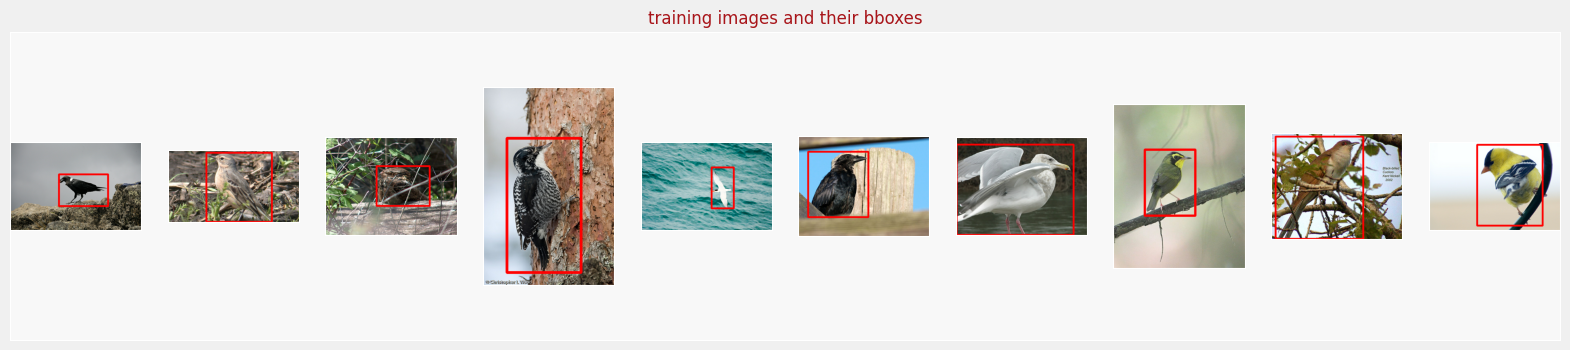

In [12]:
def get_visualization_training_dataset():
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox,
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

Visualize the **validation** images and their bounding boxes

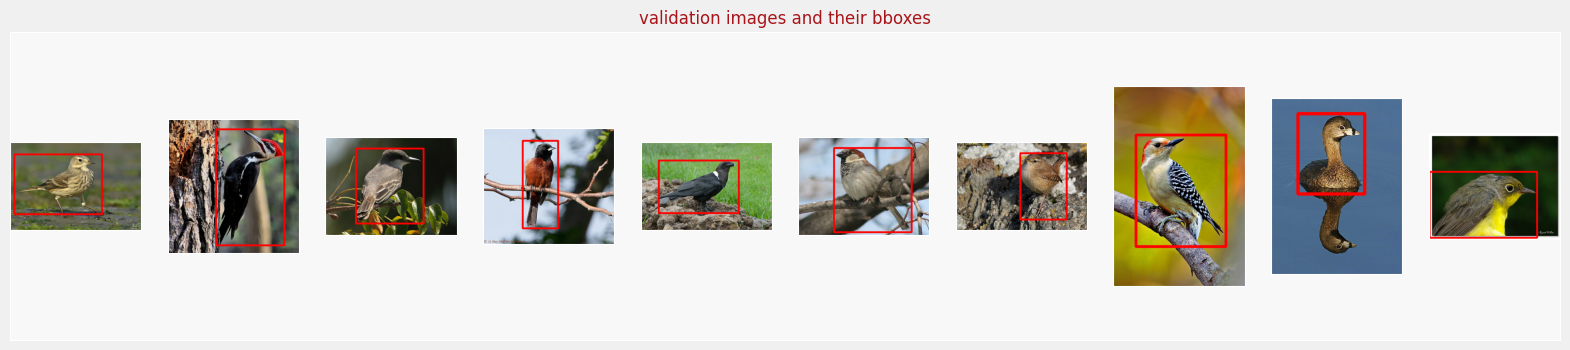

In [13]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

<a name="2-3"></a>
### 2.3 Load and prepare the datasets for the model

Read and prepare the datasets

In [14]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1)
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

<a name="3"></a>
## 3. Define the Network

<a name='ex-01'></a>
### Building a feature extractor using MobileNetV2.



In [15]:
def feature_extractor(inputs):
    # Create a mobilenet version 2 model object
    mobilenet_model = tf.keras.applications.MobileNetV2(
        input_shape=(224, 224, 3), include_top=False, weights='imagenet'
    )
    
    # pass the inputs into this modle object to get a feature extractor for these inputs
    feature_extractor = mobilenet_model(inputs)
    
    return feature_extractor

<a name='ex-02'></a>
### Defining the dense layers

In [16]:
def dense_layers(features):
    # global average pooling 2D layer.
    x = tf.keras.layers.GlobalAveragePooling2D()(features)
    
    # flatten layer
    x = tf.keras.layers.Flatten()(x)
    
    # 1024 Dense layer, with relu
    x = tf.keras.layers.Dense(1024, activation='relu')(x)
    
    # 512 Dense layer, with relu
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    
    return x

<a name='ex-03'></a>
### Define a layer that outputs the bounding box predictions

In [17]:
def bounding_box_regression(x):
    # Dense layer named `bounding_box`
    bounding_box_regression_output = tf.keras.layers.Dense(4, activation='linear', name='bounding_box')(x)


    return bounding_box_regression_output

<a name='ex-04'></a>
### Construct the model

In [18]:
def final_model(inputs):
    # features
    feature_cnn = feature_extractor(inputs)

    # dense layers
    last_dense_layer = dense_layers(feature_cnn)

    # bounding box
    bounding_box_output = bounding_box_regression(last_dense_layer)
    
    # define the TensorFlow Keras model using the inputs and outputs to your model
    model = tf.keras.Model(inputs=inputs, outputs=bounding_box_output)

    return model

<a name='ex-05'></a>
### Define the input layer, define the model, and then compile the model.

### Define the loss function

In [19]:
def localization_loss(y_true, y_pred):
    return tf.keras.losses.Huber()(y_true, y_pred)

def confidence_loss(y_true, y_pred):
    return tf.keras.losses.BinaryCrossentropy()(y_true, y_pred)

def combined_loss(y_true, y_pred):
    loc_loss = localization_loss(y_true[..., :4], y_pred[..., :4])
    conf_loss = confidence_loss(y_true[..., 4:], y_pred[..., 4:])
    return loc_loss + conf_loss

In [20]:
def define_and_compile_model():
    # define the input layer
    inputs = tf.keras.layers.Input(shape=(224, 224, 3))
    
    model = final_model(inputs)
    
    model.compile(optimizer=tf.keras.optimizers.Adam(),
                  loss=combined_loss,
                  metrics=['acc'])

    return model

Run the cell below to define your model and print the model summary.

In [21]:
# define your model
model = define_and_compile_model()
# print model layers
model.summary()

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bounding_box (Dense)            │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,096,580 (15.63 MB)

 Trainable params: 4,062,468 (15.50 MB)

 Non-trainable params: 34,112 (133.25 KB)

<a name='4'></a>
## Train the Model

In [22]:
import math

EPOCHS = 150

BATCH_SIZE = 32

length_of_training_dataset = len(visualization_training_dataset)

length_of_validation_dataset = len(visualization_validation_dataset)

steps_per_epoch = math.ceil(length_of_training_dataset / BATCH_SIZE)

validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1


In [23]:
history = model.fit(x=training_dataset, 
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset,
                    validation_steps=validation_steps,
                    epochs=EPOCHS)


Epoch 1/150
 1/94 ━━━━━━━━━━━━━━━━━━━━ 1:29:26 58s/step - acc: 0.2344 - loss: nan

I0000 00:00:1720965848.093181      71 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


94/94 ━━━━━━━━━━━━━━━━━━━━ 87s 320ms/step - acc: 0.5537 - loss: nan - val_acc: 0.5209 - val_loss: nan
Epoch 2/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 23s 240ms/step - acc: 0.7314 - loss: nan - val_acc: 0.6346 - val_loss: nan
Epoch 3/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 237ms/step - acc: 0.8075 - loss: nan - val_acc: 0.6223 - val_loss: nan
Epoch 4/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 233ms/step - acc: 0.8391 - loss: nan - val_acc: 0.5975 - val_loss: nan
Epoch 5/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - acc: 0.8716 - loss: nan - val_acc: 0.5975 - val_loss: nan
Epoch 6/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 21s 219ms/step - acc: 0.8910 - loss: nan - val_acc: 0.6035 - val_loss: nan
Epoch 7/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - acc: 0.9129 - loss: nan - val_acc: 0.6036 - val_loss: nan
Epoch 8/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 19s 206ms/step - acc: 0.9089 - loss: nan - val_acc: 0.6156 - val_loss: nan
Epoch 9/150
94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 208ms/step - acc: 0.9038 - loss: nan - val_acc: 0.6286 - 

<a name='5'></a>
## 5. Validate the Model

In [24]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

95/95 ━━━━━━━━━━━━━━━━━━━━ 9s 90ms/step - acc: 0.8447 - loss: nan
Loss:  [nan, 0.8450587391853333]


<a name='5-2'></a>
### 5.2 Plotting Loss Function

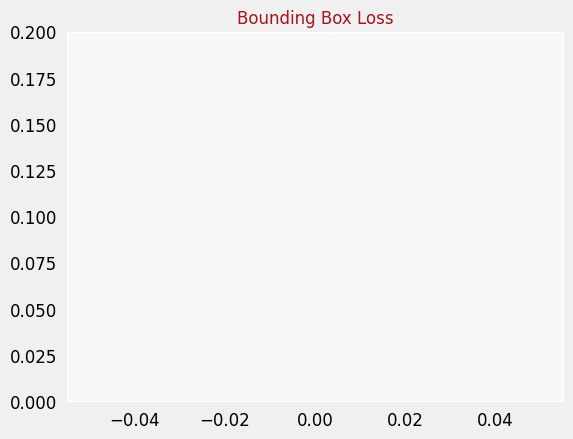

In [25]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

<a name='5-3'></a>
### 5.3 Evaluate performance using IoU

In [26]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    #Calculate coordinates of overlap area between boxes
    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    #Calculates area of true and predicted boxes
    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    #Calculates overlap area and union area.
    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    # Defines a smoothing factor to prevent division by 0
    smoothing_factor = 1e-10

    #Updates iou score
    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

#Makes predictions
original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images.astype('float32'))


#Calculates IOU and reports true positives and false positives based on IOU threshold
iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

16/16 ━━━━━━━━━━━━━━━━━━━━ 12s 395ms/step
Number of predictions where iou > threshold(0.5): 440
Number of predictions where iou < threshold(0.5): 60


<a name='6'></a>
## 6. Visualize Predictions

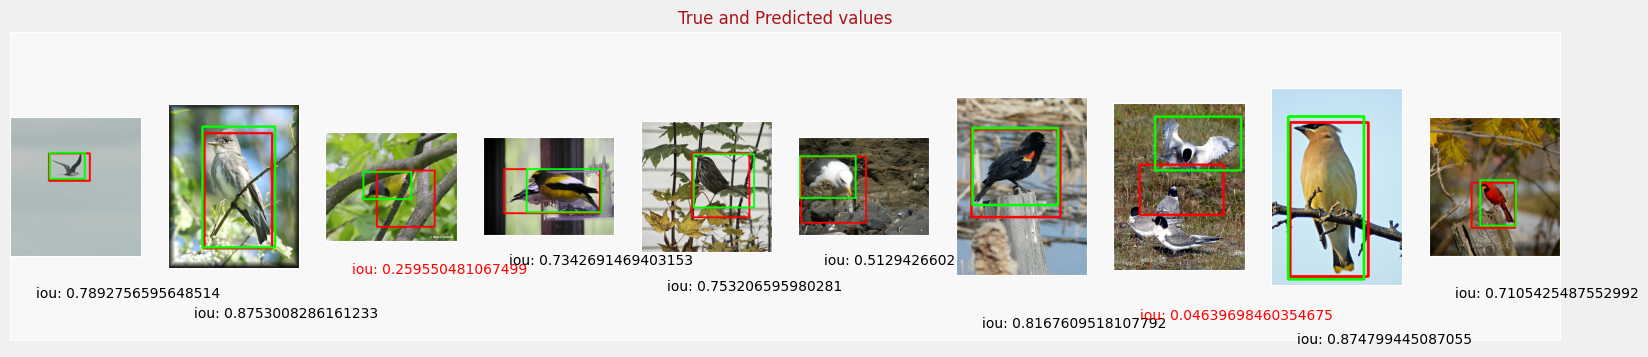

In [27]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)

In [28]:
# Save the model
model.save("/kaggle/working/temp_model.h5")